# Tutorial for srfpython

**Overview**
 + Intro : import and verify installation
 + I/ create a 1-D depth model  
 + II/ compute dispersion curves   
     + II.1/ use in a python program  
     + II.2/ use in command line   
 - III/ depth inversion  
 - III.1/ Program HerrMet  
 - III.2/ Application  
     + III.2.1/ Target data  
     + III.2.2/ Parameterization  
     + III.2.3/ Run inversion  
     + III.2.4/ Extract results

## Intro/ import and verify installation

In [1]:
# -----------------------
# import all components of srfpython
# -----------------------
from srfpython import *

In [2]:
# -----------------------
# make sure that the fortran codes have been compiled correctly
# -----------------------
try:
    check_herrmann_codes() 
    print "ok"
    
except Exception:
    print "compilation was not done or done on another system"

    # recompile
    from srfpython import recompile_src90
    recompile_src90(yes=False)

    # verify once more
    try:
        check_herrmann_codes()
        print 'sucess'
    except Exception:
        print 'Error : unexpected failure, make sure you have gfortran installed'



ok


## I/ create a 1-D depth model

In [3]:
# -----------------------
# create 1-D depth model using 4 arrays with same length
# -----------------------
ztop = [0.00, 0.25, 0.45, 0.65, 0.85, 1.05, 1.53, 1.80] #km, top layer depth, positive, increasing downward, 0 = surface
vp   = [1.85, 2.36, 2.63, 3.15, 3.71, 4.54, 5.48, 5.80] #km/s, P wave velocity in each layer
vs   = [0.86, 1.10, 1.24, 1.47, 1.73, 2.13, 3.13, 3.31] #km/s, S wave velocity in each layer
rh   = [2.47, 2.47, 2.47, 2.47, 2.47, 2.58, 2.58, 2.63] #g/cm3, Density in each layer

# create the depthmodel object, use a subclass that is to be intitiated with arrays
# see also depthmodel, depthmodel1D, depthmodel_from_mod96, ...
dm = depthmodel_from_arrays(ztop, vp, vs, rh)


# __str__ returns the file content at mod96 format, (see Herrmann CPS documentation)
print dm 

MODEL.01
MODELTITLE
ISOTROPIC
KGS
FLAT EARTH
1-D
CONSTANT VELOCITY
LINE08
LINE09
LINE10
LINE11
H(KM) VP(KM/S) VS(KM/S) RHO(GM/CC) QP QS ETAP ETAS FREFP FREFS
0.250000 1.850000 0.860000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 2.360000 1.100000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 2.630000 1.240000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 3.150000 1.470000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.200000 3.710000 1.730000 2.470000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.480000 4.540000 2.130000 2.580000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.270000 5.480000 3.130000 2.580000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000
0.000000 5.800000 3.310000 2.630000 0.000000 0.000000 0.000000 0.000000 1.000000 1.000000



In [4]:
# -----------------------
# write the depth model as a file at mod96 format (see Herrmann CPS documentation)
# -----------------------
dm.write96('dmtuto.mod96')

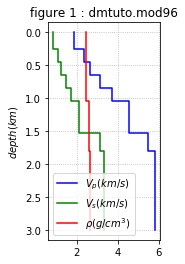

In [5]:
# -----------------------
# display the depth model
# -----------------------
plt.figure(figsize=(2, 4))
dm.show(gca())
gca().set_title('figure 1 : dmtuto.mod96')
gca().grid(True, linestyle=":")
plt.legend();

## II/ compute dispersion curves 

### II.1/ use in a python program

elapsed time dispersion : 0.014461s


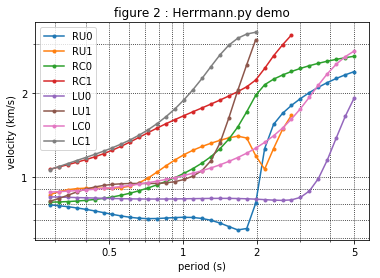

In [6]:
# -----------------------
# compute dispersion curves from the depthmodel above
# -----------------------

# define the dipsersion curves to compute
f = freqspace(0.2, 3.5, 35, "log")
curves = [Curve(wave='R', type='U', mode=0, freqs=f),
          Curve(wave='R', type='U', mode=1, freqs=f),
          Curve(wave='R', type='C', mode=0, freqs=f),
          Curve(wave='R', type='C', mode=1, freqs=f),
          Curve(wave='L', type='U', mode=0, freqs=f),
          Curve(wave='L', type='U', mode=1, freqs=f),
          Curve(wave='L', type='C', mode=0, freqs=f),
          Curve(wave='L', type='C', mode=1, freqs=f)] 

# initiate the dispersion operator
hc = HerrmannCaller(curves)

# compute dispersion curves
with Timer('dispersion'):
    # call the dispersion operator for a given depth model (defined above)
    curves = hc(ztop=ztop, vp=vp, vs=vs, rh=rh)

# display the results
ax = plt.subplot(111, xscale="log", yscale="log")
for curve in curves:
    curve.plot(ax, '.-')
logtick(ax, "xy")

ax.set_title('figure 2 : Herrmann.py demo')
plt.legend()
plt.show()

### II.2/ use in command line 

In [7]:
# -----------------------
# compute dispersion curves, and save as surf96 file
# -----------------------

!rm -f dmtuto*.surf96

!m96 --disp dmtuto.mod96 \
    -LC0 .1 10 30 plog \
    -RC1 .1 10 30 plog \
    -RU0 .1 10 30 plog \
    -save dmtuto.surf96

dmtuto.mod96 => dmtuto.surf96


dmtuto.surf96
    Claw wave=L mode=0 type=C flag=T extrapmode=0 N=30
    Claw wave=R mode=1 type=C flag=T extrapmode=1 N=22
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=30


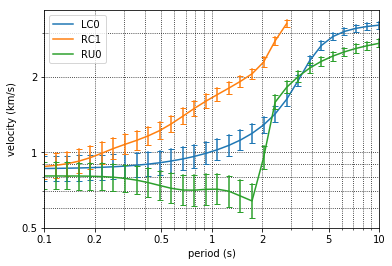

In [8]:
# -----------------------
# display output
# -----------------------

%run -i ../../srfpython/bin/s96 --show dmtuto.surf96 -inline
# in terminal, just use m96 --show dmtuto.surf96

see also programs **s96** and **m96** that provide more manipulation tools for depth models and surface wave dispersion curves in command line

In [9]:
!m96 --help
!s96 --help

m96
--show            list of mod96 files to display (same plot)
--disp            name of mod96 file to use as input
    -RU0          rayleigh, group, mode 0 : expects 4 frequency arguments : fstart, fend, nfreq, fscale
    -RU1          rayleigh, group, mode 1 : expects 4 frequency arguments : fstart, fend, nfreq, fscale
    -RC0          rayleigh, phase, mode 0 : expects 4 frequency arguments : fstart, fend, nfreq, fscale          
    -LC0          love,     phase, mode 0 : expects 4 frequency arguments : fstart, fend, nfreq, fscale
    ...
    -save         name of surf96file to write
--split 
    -thck         thickness of the sublayers in km
    -sfx          suffix to add before file extension (default split)
    -o            ignore suffix and overwrite input file
--addlayer 
    -thck         thickness of the sublayers in km
    -sfx          suffix to add before file extension (default split)
    -o            ignore suffix and overwrite input file    
-inline           rep

## III/ depth inversion

### III.1/ Program HerrMet

In [10]:
# display the main help
!HerrMet -help

HerrMet V6.0
# ------- main options (s=string, i=int, f=float)
-version, -v          version number, quit
-help, -h   [s...]    help, provide plugin names for details, quit
-example, -ex s [s..] example usage, provide plugin names for details, quit
-w           i        number of virtual workers, default None
-taskset     s        affinity, e.g. "0-3", default None
-lowprio              run processes with low priority if mentioned
-verbose     i        reduce verbosity, 0/1, default 1
# ------- plugins, use --help plugin [plugin ...] for details
--target     set the target data, create temporary directories (rootnames)
--param      create a template parameterization file
--send       send the parameterization to the temporary directories
--run        invert dispersion data using the Markov Chain Monte Carlo method
--manage     summarize run file content, manage run results
--neldermead NOT READY, optimize best solutions from run using the nelder mead algorithm
--extract    compute and 

### III.2/ Application

I invert the synthetic data created in section I (dmtuto.surf96) and compare the inversion result to the actual model used to synthetize the data (i.e. dmtuto.mod96)

#### III.2.1/ Target data

In [11]:
# display detailed help for one or more plugins
!HerrMet -help target

--target     s [s..] set the target dispersion curve(s) from surf96 file(s) (not modified)
                     for each target, I create a directory in . for temporary files
                     the data will be reproduced into a target file that can be customized manually
                     (to remove unwanted points, resample dispersion curves...) 
    -resamp  f f i s resample the dispersion curve in the target file, 
                     requires fmin(Hz), fmax(Hz), nfreq, fscale 
                     (flin=linear in freq domain, plin=linear in period or log=logarithmic scaling)
    -lunc    f       set constant uncertainties in log domain (uncertainty = value x lunc)
    -unc     f       set constant uncertainty in linear domain (uncertainty = unc)
    -ot              force overwriting _HerrMet.target if exists
    


writing _HerrMet_dmtuto/_HerrMet.target
please keep only datapoints to invert in */_HerrMet.target
use option --display to see the target data
call option --param to see prior depth boundaries


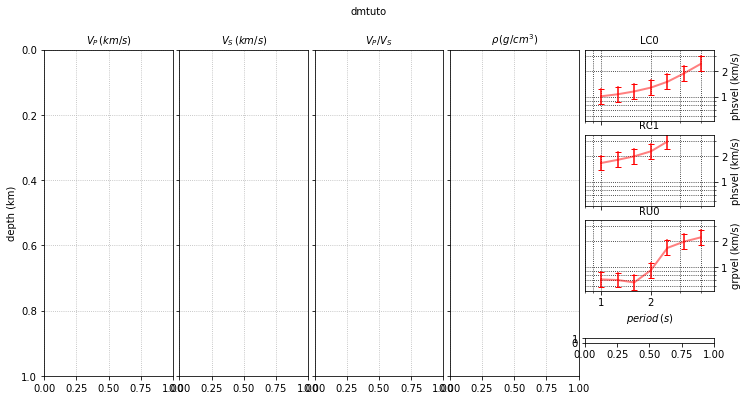

In [12]:
# -----------------------
# set the dispersion curves to invert referred to as the target data
# the dispersion curve must be provided as surf96 format (see Herrmann's doc, CPS)
# I reproduce the file content into _Herrmann.target (also at surf96 format), 
# which can be modified manually before inversion 
# (e.g. resample, remove data points or modes, adjust uncertainties for weighting, ...)
# -----------------------

# the following command will : (see HerrMet --help for command names)
# - get the target dispersion curves from dmtuto.surf96 (--target), 
# - resample it between 0.25-1 Hz with 7 samples spaced logarithmically in period domain (-resamp),
# - adjust the uncertainties to 0.2 * velocity (i.e. constant uncertainty in logaritmic domain, --lunc), 
# - overwrite the target file if exists (-ot) 

!HerrMet \
    --target dmtuto.surf96 \
        -resamp 0.25 1.0 7 plog \
        -lunc 0.2 \
        -ot

%run -i ../../srfpython/bin/HerrMet --display -inline

#### III.2.2/ Parameterization

In [13]:
# display detailed help for one or more plugins
!HerrMet -help param

--param      i f     generate a template parameter file to custom in .
                     need the number of layers and bottom depth in km
    -basedon s       build parametrization based on an existing mod96 file, require a filename, 
                     if not specified, I take fixed values to build the parameter file
    -t       s       parameterization type to use (['mZVSPRRH', 'mZVSVPRH', 'mZVSPRzRHvp', 'mZVSPRzRHz', 'mZVSVPvsRHvp']), 
                     default mZVSPRRH
          mZVSPRRH = parameterize with 
                     - depth interface (mZ1 = first interface, mZ2, ...), 
                     - VS in each layer (VS0 = first layer, ...), 
                     - VP/VS in each layer (PR0, PR1, ...), 
                     - Density in each layer (RH0, RH1, ...)
          mZVSVPRH = parameterize with  
                     - depth interface (mZ1 = first interface, mZ2, ...), 
                     - VS in each layer (VS0 = first layer, ...), 
                     - VP 

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRH'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -0.217990        -0.217990
       -Z2        -0.895334        -0.895334
       -Z3        -3.000000        -3.000000
       VS0         0.860000         0.860000
       VS1         1.281411         1.281411
       VS2         2.901682         2.901682
       VS3         3.310000         3.310000
       PR0         2.151163         2.151163
       PR1         2.137674         2.137674
       PR2         1.832729         1.832729
       PR3         1.752266         1.752266
       RH0         2.470000         2.470000
       RH1         2.470000         2.470000
       RH2         2.600424         2.600424
       RH3         2.630000         2.630000

please customize _HerrMet.param, do not change line orders and

/home/max/anaconda3/envs/py2-dev/lib/python2.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
/home/max/anaconda3/envs/py2-dev/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


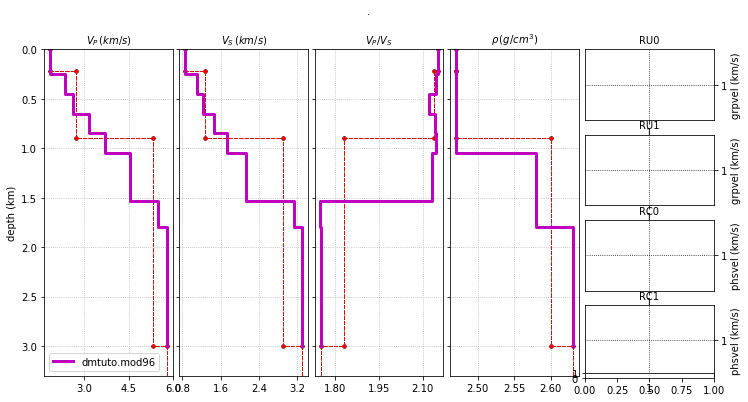

In [14]:
# -----------------------
# set the parameter file, the parameters will be stored into _Herrmet.param
# use Herrmet to generate a template version
# and customize it manually before running the inversion
# -----------------------

# the following command will :
# - set the parameter file with 4 layers down to 3 km (--param)
# - the parameters values will be adjusted based on an existing depthmodel (here dmtuto.mod96, -basedon),
# - define the parameterization mode as depth, vs, vp/vs and density (-t mZVSPRRH)
#   some other modes are available
# - require vp, vs and density to be growing (i.e. add prior constraints to the offsets between layers, -growing),             
# - overwrite the paramfile if exists (-op) 
# - display (-display) without pausing (-inline), plot also the actual model (-m96)

%run -i ../../srfpython/bin/HerrMet \
        --param 4 3. \
            -basedon dmtuto.mod96 \
            -t  mZVSPRRH \
            -growing \
            -op \
        --display .  \
            -m96 dmtuto.mod96 \
            -inline

In the above figure :
> The red dashed curves indicate the prior boundaries (lower and upper limits are equal for now)   
> The purple model is the actual model used to generate the synthetic data and to build the parameterization    

> * Note that at this step, the boundaries for each parameter (red dashed curves)   
> are the same (because VINF=VSUP in _HerrMet.param) : i.e. all parameters are locked  
> one need to adjust the VINF, VSUP boundaries for all parameters to invert  
> you may do it manually (edit _HerrMet.param),   
> here I do it with programming tools for tutorial  


> * Note also that VP is not a parameter in this example, (since we use VS and VP/VS)  
> so the boundaries displayed on the VP axis are inferred from the VS and VP/VS ones
>


In [15]:
# -----------------------
# customize the parameterization file using programming tools (for tutorial)
# You may do it manually simply by editing _Herrmet.param
# -----------------------

#load the parameter file, find lines related to top depth and to VS
A = AsciiFile('_HerrMet.param')

IZ  = np.asarray(["Z"  in _ for _ in A['KEY']], bool) #lines corresponding to Z parameters
IVS = np.asarray(["VS" in _ for _ in A['KEY']], bool) #lines corresponding to VS parameters
IPR2 = np.asarray(["PR2" in _ for _ in A['KEY']], bool) #line corresponding to VP/VS in the third layer

In [16]:
# change parameter boundaries (decrease VINF and increase VSUP), overwrite _HerrMet.param
A['VINF'][IVS] = [0.55, 0.78, 1.53, 1.65]
A['VSUP'][IVS] = [2.22, 3.15, 4.00, 4.00]
A['VINF'][IZ]  = [-.31, -1.5, -3.1]
A['VSUP'][IZ]  = [-.11, -1.1, -2.0]
A['VINF'][IPR2] = A['VSUP'][IPR2] = 1.752
print A

# overwrite the parameterization file
A.write('_HerrMet.param')

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRH'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -0.310000        -0.110000
       -Z2        -1.500000        -1.100000
       -Z3        -3.100000        -2.000000
       VS0         0.550000         2.220000
       VS1         0.780000         3.150000
       VS2         1.530000         4.000000
       VS3         1.650000         4.000000
       PR0         2.151163         2.151163
       PR1         2.137674         2.137674
       PR2         1.752000         1.752000
       PR3         1.752266         1.752266
       RH0         2.470000         2.470000
       RH1         2.470000         2.470000
       RH2         2.600424         2.600424
       RH3         2.630000         2.630000



In [17]:
# -----------------------
# send the custom version of the parameterization file to the temporary directory
# -----------------------
!HerrMet -help send

--send       s [s..] send the custom parameterization file ./_HerrMet.param to the specified rootnames, 
                     default _HerrMet_*
    -op              force overwriting ./rootname/_HerrMet.param if exists
    


In [18]:
!HerrMet --send -op

cp ./_HerrMet.param _HerrMet_dmtuto/


parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRH


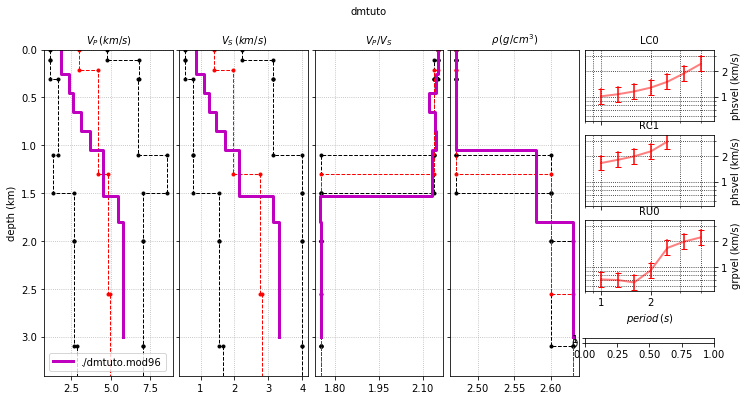

In [19]:
# -----------------------
# display the new version of the parameterization file
# -----------------------

#note that the boundaries now allow VS and Zop to vary between the black dashed lines
#note2 : here VP is not a parameter, the prior boundaries on it are infered from other parameters (VS, VP/VS)
%run -i ../../srfpython/bin/HerrMet \
    --display \
        -inline \
        -m96 ./dmtuto.mod96

#### III.2.3/ Run inversion

In [20]:
!HerrMet -help run

--run        s [s..] start inversion for the required rootnames, default _HerrMet_*
    -mode    s       set the running mode, default skip
                     restart  : overwrite the current run file(s) if any   
                     append   : add new models to the exiting run file(s) 
                     skip     : ignore rootnames with existsing run file(s)               
    -nchain  i       number of chains to use, default 12
    -nkeep   i       number of models to keep per chain, default 100
    [use -w option before --run to control the maximum number of chains to run simultaneously]   
    


In [21]:
# -----------------------
# run the inversion, will load the parameterization and target data,
# and generate markov chains to sample the posterior pdf (in parallel)
# the models generated by the chains will be stored in a sqlite database (_HerrMet.run)
# -----------------------

# the following command will :
# - run the inversion with 12 markov chains in restart mode (overwrites _HerrMet.run if exists)
# - each chain will keep 100 models
# - use 4 virtual threads (-w) affected to the first 4 physical threads (-taskset)
!HerrMet \
    -w 4 \
    -taskset "0-3" \
    -verbose 0 \
    --run \
        -mode restart \
        -nchain 12 \
        -nkeep 100

print "DONE"
        
# notations :
# kept : the number of models kept by the markov chain over the number of tests
# fail : some models can lead to failure of the forward algo (CPS), 
#        we consider them as models with no image in the dataspace
#        the penalty is adjusted to force the chains to move away from these dead ends
# AK   : Average keep ratio : the number of models kept / the number of tests
#        by default, the proposal pdf is adjusted to maintain this value around .25
# MP   : Master proposal : a coefficient to adjust the proposal distance according to AK
# AS   : Average speed : the average number of models tested per second and per chain
# LI   : Final log likelyhood = the quality of the last model found (not necessarily the best)

pid 3454's current affinity list: 0-7
pid 3454's new affinity list: 0-3
parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRH
pid 3470's current affinity list: 0-3
pid 3470's new affinity list: 0-3
pid 3471's current affinity list: 0-3
pid 3471's new affinity list: 0-3
pid 3473's current affinity list: 0-3
pid 3473's new affinity list: 0-3
pid 3474's current affinity list: 0-3
pid 3474's new affinity list: 0-3
pid 3469's current affinity list: 0-3
pid 3469's new affinity list: 0-3
    dmtuto chain    3  DONE kept  100/  493 fail   29 AK 0.20 MP 0.45 AS 195.57/s BST -2.501622
    dmtuto chain    2  DONE kept  100/  497 fail   12 AK 0.20 MP 0.45 AS 184.94/s BST -1.091029
    dmtuto chain    1  DONE kept  100/  530 fail   14 AK 0.19 MP 0.33 AS 187.16/s BST -3.688247
    dmtuto chain    0  DONE kept  100/  541 fail   30 AK 0.18 MP 0.31 AS 189.55/s BST -0.804376
    dmtuto chain    4  DONE kept  100/  530 fail   18 AK 0.19 MP 0.35 AS 183.48/s BST -0.953679
    dmtuto 

In [22]:
# -----------------------
# see the convergence of the chains, delete chains or bad models
# -----------------------
!HerrMet -help manage

--manage     s [s..] manage run results for given rootnames, default _HerrMet_*
     -stats          prints detailed stats for each chain of each runfile 
     -plot   [f]     display the convergence for every chain and every rootname, specify the lower bound
     -inline         do not pause (jupyter)
     -delbad f       delete bad models, log likelihood below a given threshold, no default
     -delchains i [i...] delete one or more chains using their chainid
      



_HerrMet_dmtuto :     12 chains,   1212 models, worst -217954.032013, best  -0.713665, filesize 0M


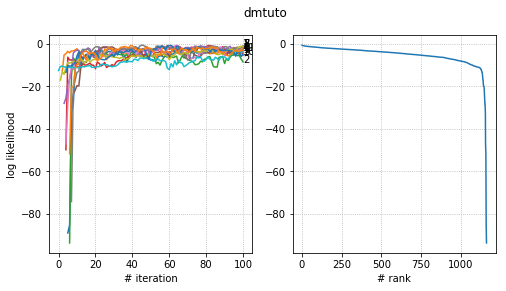

In [23]:
%run -i ../../srfpython/bin/HerrMet -verbose 0 --manage -delbad -100. -plot -inline

--display   s [s...] display param, target, and run outputs for the required rootnames, default _HerrMet_*
                     (use "." to see the parameterzation template ./_HerrMet.param from option --param)
    -plot  [s i f i] show the best models on the figure, arguments are :  
                     first argument = selection mode, last or best
                     second argument = highest model number to include (>=0, 0 means all)  
                     third argument = lowest log likelihood value to include (<=0.0, 0.0 means all)
                     fourth argument = include only one model over "step" (>=1)
                     default last 100 0.0 1             
    -overdisp        recompute dispersion curves of the best models selected with higher resolution
    -pdf   [s i f i] compute and show the statistics for the selected models, see -plot for arguments
                     default last 0 0.0 1 
                     use --extract to save pdf outputs
    -png   [i]    

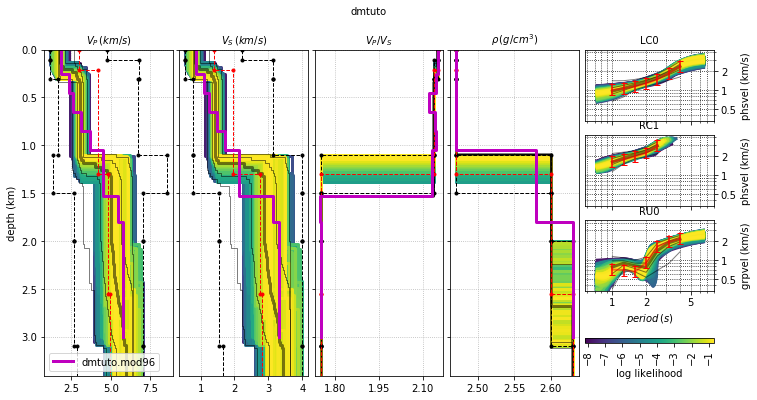

In [24]:
# -----------------------
# display the results, by selecting models in the sqlite database (_HerrMet.run)
# -----------------------

# the following command will :
# - display the best 1000 models found and their image in the dataspace (-plot)
# - recompute the dispersion curves with higher resolution (-overdisp)
# - compute the median and std of the full population of models (-pdf)
# - add the model used to synthetize the data (dmtuto.mod96) for comparison (-m96)
!HerrMet -help display
%run -i ../../srfpython/bin/HerrMet \
        -verbose 0 \
        --display \
            -plot best 1000 0. 1 \
            -overdisp \
            -pdf \
            -inline \
            -m96 dmtuto.mod96


In the figure above:
> The black doted models are the prior boundaries  
> The red dispersion curves are the target data  

> The colored models are the 1000 best models sorted by increaseing likelyhood (see colorbar)   
> The colored dispersion curves = corresponding data, recomputed with higher resolution (overdisp)

> The gray models are the median (thick), 16% and 84% aposteriori percentiles (thin) computed from the full population of models
> The purple model is the actual model used to generate the synthetic data = expected solution  


#### III.2.4/ Extract results

In [25]:
# -----------------------
# HerrMet can create figures, 
# however you probably need to get the results at numerical format for further analysis
# use option --extract to compute and save the posterior pdf purcentiles
# -----------------------

# the following command will:
# -compute the median and std of the best 1000 models found, 
# -save it as mod96 files named 
#     _HerrMet.p0.16.mod96,_HerrMet.p0.50.mod96 and _HerrMet.p0.84.mod96
!HerrMet -help extract
%run -i ../../srfpython/bin/HerrMet \
    -verbose 0 \
    --extract \
        -pdf best 1000 0.0 1 

--extract    s [s..] rootnames for which to compute and extract pdf, default _HerrMet_*
    -pdf   [s i f i] extract posterior distribution of the models, save them as mod96files
                     first argument = selection mode, last or best
                     second argument = highest model number to include (>=0, 0 means all)  
                     third argument = lowest log likelihood value to include (<=0.0, 0.0 means all)
                     fourth argument = include only one model over "step" (>=1)
                     default last 0 0 1
    -top     [i f i] extract best models 
                     first argument = highest model number to include (>=0, 0 means all)
                     second argument = lowest log likelihood value to include (<=0.0, 0.0 means all)  
                     third argument = include only one model over "step" (>=1)
                     default 10 0.0 1
                     
extract : llkmin 0.000000, limit 1000, step 1 retrieved 1000 models i

_HerrMet_dmtuto/_HerrMet.best_1000_0.0_1.p0.16.mod96
_HerrMet_dmtuto/_HerrMet.best_1000_0.0_1.p0.84.mod96
_HerrMet_dmtuto/_HerrMet.best_1000_0.0_1.p0.50.mod96
dmtuto.mod96


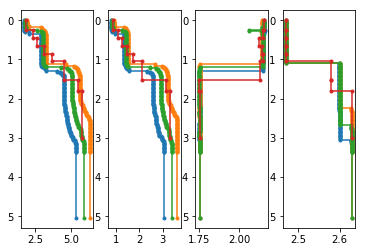

In [26]:
#display models from --extract using m96
%run -i ../../srfpython/bin/m96 --show _HerrMet_*/_HerrMet.best*p*.mod96 dmtuto.mod96 -inline

In [27]:
# clear temporary files
import glob, os
os.system('rm -rf dmtuto.*96 _HerrMet*')
for _ in glob.iglob('./*'):
    print _,

./00_how_to_use_srfpython.ipynb ./readme.txt ./00_how_to_use_srfpython.html
